### Evaluation notebook

Evaluates on `HPatches` dataset.

For an R2D2-like model, given that you have run the inference script `relfm/inference/r2d2_on_hpatches.py` that generates outputs, you can run this notebook to test rotation equivariance of local feature matching.

## Table of Contents

* [Imports](#imports)
* [Configure inputs](#configure_inputs)
* [Generate results](#generate_results)
* [Plot results](#plot_results)

> *Warning*: This notebook takes about 9-10 minutes for generating results per model.

### Imports <a class="anchor" id="imports"></a>

Basic imports.
> Note that you should set `PYTHONPATH=/path/to/repo/:/path/to/repo/lib/r2d2/` before running the environment.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join, exists, expanduser
from genericpath import isdir
from glob import glob
import numpy as np
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import torch

from lib.r2d2.extract import extract_keypoints_modified
from relfm.utils.paths import REPO_PATH
from relfm.utils.log import print_update, tqdm_iterator
from relfm.utils.visualize import show_images_with_keypoints, check_kps_with_homography
from relfm.utils.matching import evaluate_matching_with_rotation, analyze_result
from relfm.utils.geometry import (
    append_rotation_to_homography, apply_homography_to_keypoints, resize, apply_clean_rotation,
)

In [3]:
set_latex_fonts(show_sample=True)

NameError: name 'set_latex_fonts' is not defined

### Configure inputs <a class="anchor" id="configure_inputs"></a>

Set the correct data and output paths as well as the model checkpoint that you'd like to evaluate on. Parameters such as `gap_between_rotations` and `imsize` (size of downsized image to evaluate) are hard-coded to be the same as the default values in the inference script.

In [4]:
data_dir = join(REPO_PATH, "data/hpatches-sequences-release/")

model_ckpt_paths = {
    # "R2D2": join(REPO_PATH, "checkpoints/r2d2_WASF_N16.pt"),
    # "R2D2 - $C_{4}$": join(REPO_PATH, "trained_models/epoch_16_test_model.pt"),
    "R2D2 - $SO_{2}$ (Ep 4)": join(REPO_PATH, "trained_models/epoch_3_SO2_4x16_1x32_1x64_2x128.pt"),
    # "R2D2 - $C_{8}$ (Ep 4)": join(REPO_PATH, "trained_models/epoch_3_C8_4x16_1x32_1x64_2x128.pt"),
    # "R2D2 - $SO_{2}$ (Ep 18)": join(REPO_PATH, "trained_models/epoch_17_SO2_4x16_1x32_1x64_2x128.pt"),
}

output_dir = join(expanduser("~"), "outputs/rotation-equivariant-lfm")

In [8]:
assert isdir(data_dir)
assert isdir(output_dir)
# assert exists(model_ckpt_path)

gap_between_rotations=15
downsize=True
imsize=300

ignore_cache = True
overwrite_cache = False

ransac = True
ransac_threshold = 3.

sanity_check = False
crop_post_rotation = True

### Generate results <a class="anchor" id="generate_results"></a>

In [19]:
results = dict()

# load image sequences
sequences = sorted(glob(join(data_dir, "*")))

# load rotation values between 0 and 360 degrees
rotations = np.arange(0, 360 + 1, gap_between_rotations, dtype=int)

# set a (list of) pixel threshold value across which to evaluate rotation robustness
thresholds = [3.]

# set this to true to see intermediate outputs/messages
verbose = False

for model_name, model_ckpt_path in model_ckpt_paths.items():

    # save directory
    save_dir = configure_save_dir(output_dir, model_ckpt_path, dataset_name="hpatches")

    metrics_path = join(save_dir, "metrics.pt")
    if exists(metrics_path) and not ignore_cache:
        print_update(f"Loading cached results for {model_name}")
        results[model_name] = torch.load(metrics_path)["MMA"]
        continue
    
    print_update(f"Generating results for {model_name}")

    # computing Mean Matching Accuracy (MMA)
    mma = defaultdict(list)
    counter = 1
    for sequence in sequences:

        # store sequence name
        sequence_name = os.path.basename(sequence)

        # load source image
        img1_path = join(sequence, "1.ppm")
        img1_raw = Image.open(img1_path)

        # define base homography for source image
        H1_raw = np.eye(3)

        # possible indices of the target images
        img2_indices = np.arange(2, 7)

        # load all target images at once
        img2s_raw = [Image.open(join(sequence, f"{i}.ppm")) for i in img2_indices]

        # define base homography for each target image
        H2s_raw = [np.eye(3) for _ in img2s_raw]
        
        if downsize:
            # downsize the source image to (args.imsize, args.imsize)
            img1_resized, H1_raw = resize(img1_raw, imsize, imsize)

            # downsize the target images to (args.imsize, args.imsize)
            img2s_resized = []
            for j in range(len(img2s_raw)):
                img, H2s_raw[j] = resize(img2s_raw[j], imsize, imsize)
                img2s_resized.append(img)
        else:
            img1_resized = img1_raw
            img2s_resized = img2s_raw
            
        # load all homographies
        H1to2s = [np.loadtxt(join(sequence, f"H_1_{i}")) for i in img2_indices]

        rotation_grid, img2_indices_grid  = np.meshgrid(rotations, img2_indices)
        rotation_grid, img2_indices_grid = rotation_grid.flatten(), img2_indices_grid.flatten()
        iterator = tqdm_iterator(
            range(len(rotation_grid)),
            desc=f"Evaluating predictions for {sequence_name} ({counter}/{len(sequences)})\t\t",
        )
        for i in iterator:
            rotation, img2_index = rotation_grid[i], img2_indices_grid[i]

            img1 = img1_resized.copy()

            # index target image
            img2 = img2s_resized[img2_index - 2].copy()

            # load base homography for source and target image
            H1 = H1_raw.copy()
            H2 = H2s_raw[img2_index - 2].copy()

            if crop_post_rotation:
                # center crop the source image according to the rotation
                # NOTE: this does not rotate the image, only crops based on rotation
                _, _, img1_transformed, H1 = apply_clean_rotation(
                    image=img1, degrees=rotation, H=H1
                )

                # rotate + center crop the target image
                # NOTE: this applies rotation and then cropping
                img2_transformed, H2, _, _ = apply_clean_rotation(
                    image=img2, degrees=rotation, H=H2,
                )
            else:
                img1_transformed = img1
                img2_transformed = img2.rotate(rotation)
                H2 = append_rotation_to_homography(H2, rotation, img1.size[0], img1.size[1])
            
            # transform the homography accordingly
            H = H1to2s[img2_index - 2].copy()
            H_transformed = H2 @ H @ np.linalg.inv(H1)

            # load outputs for source image
            save_path = join(
                save_dir, sequence_name, f"1_rotation_{rotation}.npy",
            )
            img1_outputs = np.load(save_path, allow_pickle=True).item()
            
            # load outputs for target image
            save_path = join(
                save_dir, sequence_name, f"{img2_index}_rotation_{rotation}.npy",
            )
            img2_outputs = np.load(save_path, allow_pickle=True).item()
            
            # load H
            # H1 = img1_outputs["H1"]
            # H2 = img2_outputs["H2"]
            # H = H1to2s[img2_index - 2].copy()
            # H_transformed = H2 @ H @ np.linalg.inv(H1)
            
            # get keypoints and descriptors from the outputs
            kps1 = img1_outputs["keypoints"]
            des1 = img1_outputs["descriptors"]

            kps2 = img2_outputs["keypoints"]
            des2 = img2_outputs["descriptors"]

            # show detected keypoints
            if verbose and rotation == 30 and img2_index == 4:
                show_images_with_keypoints(
                    [img1_transformed, img2_transformed],
                    [kps1, kps2],
                    radius=2,
                )

            # perform matching
            width, height = img2_transformed.size
            result = evaluate_matching_with_rotation(
                kp1=kps1,
                des1=des1,
                kp2=kps2,
                des2=des2,
                H=H_transformed,
                width=width,
                height=height,
                rotation=0,
                return_metadata=True,
                threshold=3.,
                ransac=ransac,
                ransac_threshold=ransac_threshold,
            )

            # show matching results
            if verbose and rotation == 30 and img2_index == 4:
                analyze_result(
                    img1_transformed, img2_transformed, result, K=10, radius=5,
                )

            # compute accuracy across various thresholds
            _match_accu = []
            for threshold in thresholds:
                _match_accu.append(np.mean(result["distances"] < threshold))

            mma[rotation].append(np.mean(_match_accu))

        counter += 1

        if verbose:
            break

    # compute the mean matching accuracy (MMA) for every rotation value
    mma_avg = {k:np.array(mma[k]).mean() for k in mma}
    
    if overwrite_cache:
        # save metrics
        metrics = {
            "MMA": mma_avg,
        }
        torch.save(metrics, metrics_path)
    
    # collect results
    results[model_name] = mma_avg

:::::::::::::::::::::::::::::::::::::::::::::: Generating results for R2D2 - $SO_{2}$ (Ep 4) :::::::::::::::::::::::::::::::::::::::::::::::


Evaluating predictions for i_ajuntament (1/116)		: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]                        
Evaluating predictions for i_castle (8/116)		:  46%|████▋     | 58/125 [00:11<00:12,  5.24it/s]                             


KeyboardInterrupt: 

### Plot results <a class="anchor" id="plot_results"></a>

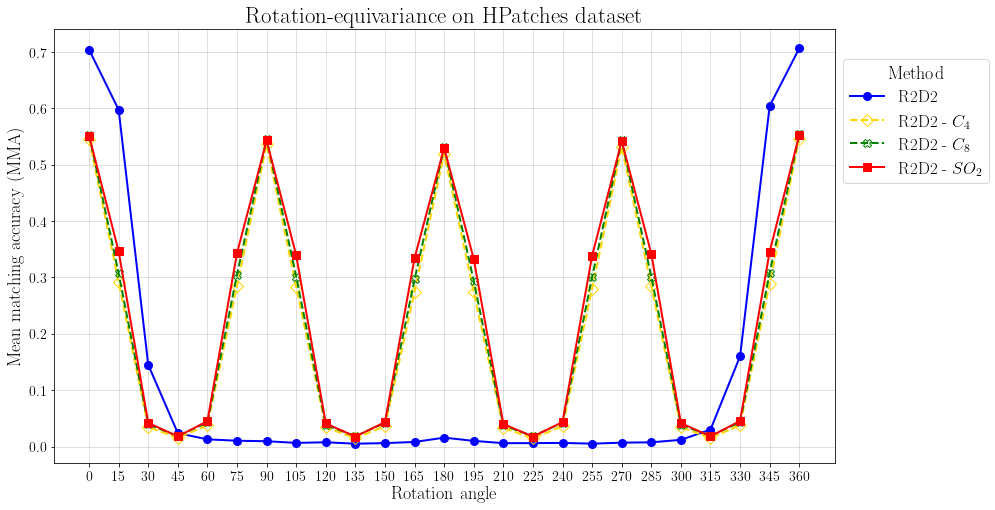

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

ax.grid(alpha=0.5)
# ax.set_ylim((0., 1.))
ransac_suffix = " (with RANSAC) " if ransac else ""
ax.set_title(f"Rotation-equivariance on HPatches dataset {ransac_suffix}", fontsize=23)
ax.set_xlabel("Rotation angle ", fontsize=18)
ax.set_ylabel("Mean matching accuracy (MMA)", fontsize=18)

i = 0
colors = get_colors(num_colors=len(results), palette="terrain")
colors = ["blue", "gold", "#b355ed", "green", "red"]
markers = ["o", "D", "^", "X", "s"]
linestyles = ["solid", "dashed", "dashed", "dashed", "solid"]
fillstyles = ["full", "none", "none", "none", "full"]
for model_name, mma_avg in results.items():
    
    if i == 2:
        i += 1
        continue

    ax.plot(
        list(mma_avg.keys()),
        list(mma_avg.values()),
        label=model_name.split(" (")[0],
        markersize=8,
        linewidth=2.,
        color=colors[i],
        marker=markers[i],
        linestyle=linestyles[i],
        fillstyle=fillstyles[i],
    )
    i += 1
    ax.set_xticks(list(mma_avg.keys()))

ax.legend(fontsize=17, bbox_to_anchor=(1., 0.95), title="Method", title_fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

os.makedirs("../Figures/", exist_ok=True)
plt.savefig(f"../Figures/mma_hpatches_without_RANSAC-v1.0.pdf", bbox_inches="tight")
plt.show()